# Data Cleaning


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

df = pd.read_csv('7282_1.csv')
## Rename columns 
df.rename(columns = {'reviews.rating':'ratings', 'reviews.text':'reviews','reviews.username':'username'}, inplace = True)

## drop null values
df.dropna(subset=['ratings'], inplace=True)
df.dropna(subset=['reviews'], inplace=True)

## drop duplicates
df.drop_duplicates(subset=['username'])
df.dropna(subset=['ratings'], inplace=True)

## drop row 98 that has an invalid review "xxxxxxxxxxxxxxx"
df.drop(98, inplace=True)

df.reset_index(drop=True, inplace = True)

## standardize the ratings
filtered_values = df.loc[df['ratings'] > 5, 'ratings']
# Divide the filtered values by 2
filtered_values_divided = filtered_values / 2
# Update the original DataFrame with the new values
df.loc[df['ratings'] > 5, 'ratings'] = filtered_values_divided


## categorizing ratings
df.loc[(df['ratings'] >= 4.5), 'ratings'] = 5.0

df.loc[(df['ratings'] >= 3.5) & (df['ratings'] < 4.5), 'ratings'] = 4.0

df.loc[(df['ratings'] >= 2.5) & (df['ratings'] < 3.5), 'ratings'] = 3.0

df.loc[(df['ratings'] >= 1.5) & (df['ratings'] < 2.5), 'ratings'] = 2.0

df.loc[(df['ratings'] >= 0.5) & (df['ratings'] < 1.5), 'ratings'] = 1.0

df.loc[(df['ratings'] < 0.5), 'ratings'] = 0.0

## sentiment mask based on ratings 
df['sentiment'] = df['ratings'].map({0:'negative', 1:'negative', 2:'negative', 3:'neutral', 4:'positive', 5:'positive'})
df = df[['reviews', 'sentiment']]

## drop all rows where sentiment is neutral
df.drop(df[df['sentiment'] =='neutral'].index, inplace=True)

#converting labels to 0 and 1
df['sentiment'] = df['sentiment'].map({'negative':0, 'positive':1})



# Preprocessing data

In [2]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def remove_Stopwords(text):
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words]
    return " ".join(words)

#change word back to its original form
def lemmatize_text(text):
    wordlist = []
    lemmatizer = WordNetLemmatizer()
    sentences = sent_tokenize(text)
    for sentence in sentences:
        words = word_tokenize(sentence)
        words = [lemmatizer.lemmatize(word) for word in words]
        wordlist.append(" ".join(words))
    return " ".join(wordlist)

#remove special characters and punctuations from the text
def clean_text(text):
    delete_dic = {sp_character: "" for sp_character in string.punctuation}
    delete_dic[" "] = " "
    table = str.maketrans(delete_dic)
    text1 = text.translate(table)
    textArr = text1.split()
    text2 = " ".join([word for word in textArr])
    return text2.lower()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aymanadil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aymanadil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aymanadil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Cleaned data 

In [3]:
df['reviews'] = df['reviews'].apply(clean_text)
df['reviews'] = df['reviews'].apply(remove_Stopwords)
df['reviews'] = df['reviews'].apply(lemmatize_text)

# negative_df = df[df['sentiment'] == 'negative']
# negative_df.head(10)

In [4]:
# df.drop(df[df['sentiment'] == 'neutral'].index, inplace=True)

df.shape

(29243, 2)

# Splitting data

In [5]:
from sklearn.model_selection import train_test_split
X = df['reviews']
y = df['sentiment']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(23394,) (23394,)
(5849,) (5849,)


# Preparing embedding layer

In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalMaxPooling1D, Embedding 

word_tokenize = Tokenizer()
word_tokenize.fit_on_texts(X_train) # creates a dictionary mapping each unique word found in training data - this process is often called "building a vocabulary"
# ^ the frequency of each word is also calculated in this phase, this can be useful for tasks like filtering out infrequent words

X_train = word_tokenize.texts_to_sequences(X_train) # takes text and turns them into a list of numbers - each number represents a specific word in the library
X_test = word_tokenize.texts_to_sequences(X_test)

vocab_size = len(word_tokenize.word_index) + 1
maxlen = max([len(x) for x in X_train])
print(maxlen)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen) # adds zeros to make sure that all of sequences have the same length
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


289


### Creating feature matrix using GloVe word embeddings

In [8]:
from numpy import asarray
from numpy import zeros

In [9]:
embeddings_dict = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file: # iterating over every line in the glove_file
  # process each line to extract the word and its vector representation
  records = line.split()
  word = records[0]
  # the embedding word vector is obtained by converting the rest of the list
  # int a NumPy array with float32. This is needed because the the embedding dimension
  # is sorted as a string in the file and we need it to be a floating point number
  # for any mathematical operation we might perform
  vector_dimensions = asarray(records[1:], dtype='float32')
  embeddings_dict[word] = vector_dimensions

glove_file.close()

# Creating embedding matrix 
this will contain 100 dimensional GloVe word embeddings for all words 
in our corpus.
The embedding layer of a neural network is the part of the network that takes input data by 
transforming it into dense vectors of fixed size, often at the very beginning of the model's architecture

In [10]:

# here we initialize the embedding matrix with zeros
# this creates a matrix filled with zeros where the number of rows (vocab_size)
# represents the size of our dataset's vocabulary. and the number of columns 
# represents the dimensionality of teh GloVe vectors we're using
embedding_matrix = zeros((vocab_size, 100))
# here we fill teh embedding matrix with embedding vectors from 'embeddings_dict'
for word, index in word_tokenize.word_index.items():
  embedding_vector = embeddings_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

embedding_matrix.shape

(28258, 100)

# Creating a Simple Neural Network

In [11]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length = maxlen, trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

#### Model compiling

In [12]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 289, 100)          2825800   
                                                                 
 flatten (Flatten)           (None, 28900)             0         
                                                                 
 dense (Dense)               (None, 1)                 28901     
                                                                 
Total params: 2854701 (10.89 MB)
Trainable params: 28901 (112.89 KB)
Non-trainable params: 2825800 (10.78 MB)
_________________________________________________________________
None


#### Model Training

In [13]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
147/147 [==============================] - 0s 2ms/step - loss: 0.3947 - acc: 0.8271 - val_loss: 0.3310 - val_acc: 0.8547
Epoch 2/6
147/147 [==============================] - 0s 1ms/step - loss: 0.2997 - acc: 0.8731 - val_loss: 0.3131 - val_acc: 0.8636
Epoch 3/6
147/147 [==============================] - 0s 1ms/step - loss: 0.2722 - acc: 0.8868 - val_loss: 0.3082 - val_acc: 0.8686
Epoch 4/6
147/147 [==============================] - 0s 1ms/step - loss: 0.2561 - acc: 0.8967 - val_loss: 0.3111 - val_acc: 0.8686
Epoch 5/6
147/147 [==============================] - 0s 2ms/step - loss: 0.2459 - acc: 0.9003 - val_loss: 0.3084 - val_acc: 0.8713
Epoch 6/6
147/147 [==============================] - 0s 1ms/step - loss: 0.2364 - acc: 0.9054 - val_loss: 0.3098 - val_acc: 0.8726


#### Predictions on test set

In [14]:
score = snn_model.evaluate(X_test, y_test, verbose=1)
print("test set score: ", score[0])
print("test set accuracy: ", score[1])

183/183 [==============================] - 0s 681us/step - loss: 0.3188 - acc: 0.8709
test set score:  0.3187728524208069
test set accuracy:  0.8709180951118469


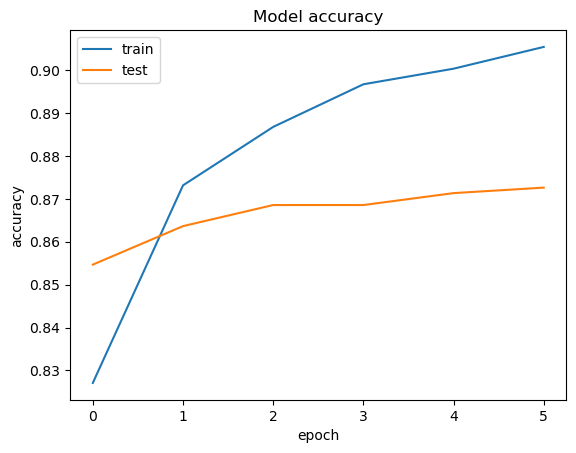

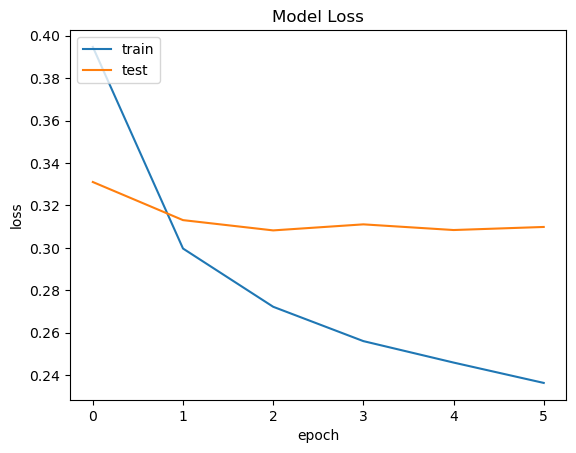

In [15]:
# Plotting charts for performance
import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Model Analysis
we can clearly see that some overfitting has taken place, our training accuracy is much higher than our testing accuracy 

# Creating a Convolutional Neural Net

In [16]:
from keras.layers import Conv1D

In [17]:
# Basic architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [18]:
# Model compiling 

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 289, 100)          2825800   
                                                                 
 conv1d (Conv1D)             (None, 285, 128)          64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2890057 (11.02 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 2825800 (10.78 MB)
_________________________________________________________________
None


#### Training  convolutional net

In [19]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
147/147 [==============================] - 5s 35ms/step - loss: 0.3247 - acc: 0.8623 - val_loss: 0.2846 - val_acc: 0.8820
Epoch 2/6
147/147 [==============================] - 5s 37ms/step - loss: 0.2500 - acc: 0.8993 - val_loss: 0.2760 - val_acc: 0.8839
Epoch 3/6
147/147 [==============================] - 5s 35ms/step - loss: 0.2108 - acc: 0.9171 - val_loss: 0.2677 - val_acc: 0.8865
Epoch 4/6
147/147 [==============================] - 5s 37ms/step - loss: 0.1795 - acc: 0.9344 - val_loss: 0.2614 - val_acc: 0.8972
Epoch 5/6
147/147 [==============================] - 5s 35ms/step - loss: 0.1524 - acc: 0.9471 - val_loss: 0.2647 - val_acc: 0.8882
Epoch 6/6
147/147 [==============================] - 5s 35ms/step - loss: 0.1246 - acc: 0.9608 - val_loss: 0.2779 - val_acc: 0.8880


In [20]:
print('Convolutional net score: ', score[0])
print('Convolutional net loss: ', score[1])

Convolutional net score:  0.3187728524208069
Convolutional net loss:  0.8709180951118469


#### Convolutional Net Performance Charts

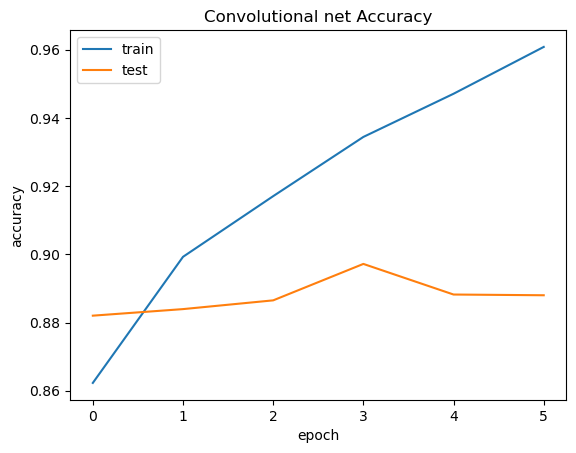

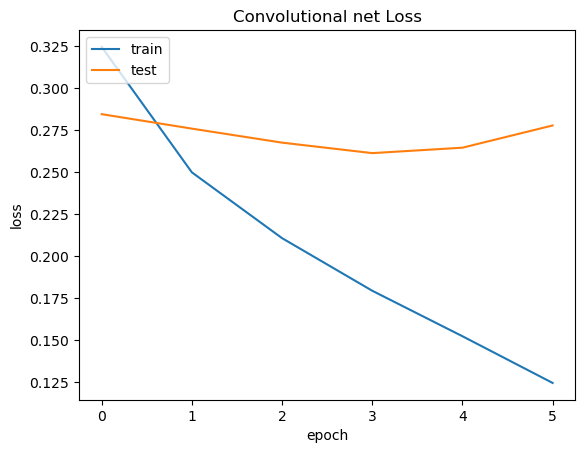

In [21]:
import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('Convolutional net Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('Convolutional net Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Recurrent Neural Net (LSTM)

In [22]:
from keras.layers import LSTM

In [23]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(228))

lstm_model.add(Dense(1, activation='sigmoid'))

In [24]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 289, 100)          2825800   
                                                                 
 lstm (LSTM)                 (None, 228)               300048    
                                                                 
 dense_2 (Dense)             (None, 1)                 229       
                                                                 
Total params: 3126077 (11.93 MB)
Trainable params: 300277 (1.15 MB)
Non-trainable params: 2825800 (10.78 MB)
_________________________________________________________________
None


#### Training LSTM model

In [25]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
147/147 [==============================] - 111s 754ms/step - loss: 0.5647 - acc: 0.7741 - val_loss: 0.5194 - val_acc: 0.7863
Epoch 2/6
147/147 [==============================] - 118s 801ms/step - loss: 0.5272 - acc: 0.7807 - val_loss: 0.5189 - val_acc: 0.7863
Epoch 3/6
147/147 [==============================] - 119s 813ms/step - loss: 0.5264 - acc: 0.7807 - val_loss: 0.5205 - val_acc: 0.7863
Epoch 4/6
147/147 [==============================] - 113s 772ms/step - loss: 0.5264 - acc: 0.7807 - val_loss: 0.5190 - val_acc: 0.7863
Epoch 5/6
147/147 [==============================] - 117s 800ms/step - loss: 0.5267 - acc: 0.7807 - val_loss: 0.5189 - val_acc: 0.7863
Epoch 6/6
147/147 [==============================] - 120s 815ms/step - loss: 0.5267 - acc: 0.7807 - val_loss: 0.5196 - val_acc: 0.7863


In [26]:
lstm_score = lstm_model.evaluate(X_test, y_test, verbose=1)
print('lstm model accuracy: ', lstm_score[0])
print('lstm model loss: ', lstm_score[1])

183/183 [==============================] - 41s 223ms/step - loss: 0.5260 - acc: 0.7810
lstm model accuracy:  0.5259766578674316
lstm model loss:  0.7809882164001465


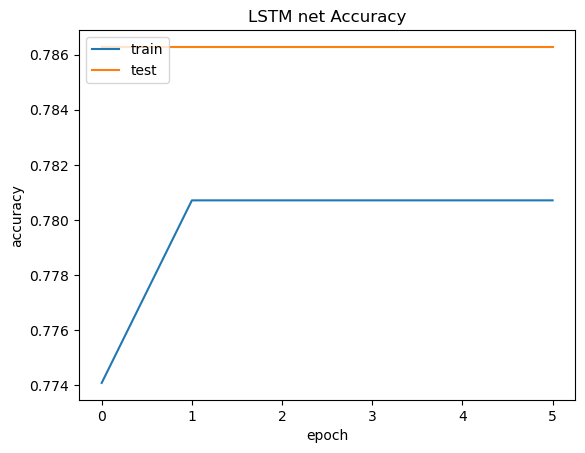

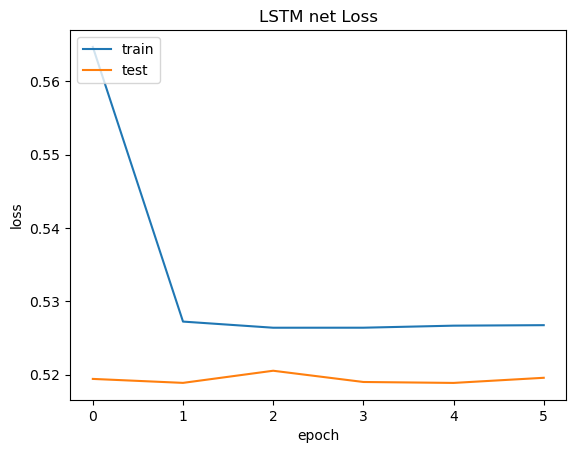

In [27]:

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('LSTM net Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('LSTM net Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()